<h1>Data Exploration</h1>

### Summary of Findings:

- 928 out of the total 1001 samples have full profiles available
- There are many features for cell lines, it is a sparse matrix
- Cosmic identifier is the cell line the drug was tested on 

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
_FOLDER = "../data/"

import os
import gc
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import scipy.optimize as opt
from tqdm import tqdm

In [2]:
cell_lines = pd.read_csv(_FOLDER+'Cell_Lines_Details.csv')
print(cell_lines.shape)
cell_lines.head()

(1001, 13)


,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\rResponse,GDSC\rTissue descriptor 1,GDSC\rTissue\rdescriptor 2,Cancer Type\r(matching TCGA label),Microsatellite \rinstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


In [3]:
to_rename_columns = {"Drug\rResponse": 'Drug/Response', 
                 'GDSC\rTissue descriptor 1': "GDSC/Tissue descriptor 1",
                  'GDSC\rTissue\rdescriptor 2':'GDSC/Tissue descriptor 2', 
                  'Cancer Type\r(matching TCGA label)':'Cancer Type/(matching TCGA label)',
                  'Microsatellite \rinstability Status (MSI)':'Microsatellite/instability Status (MSI)',
                 }
cell_lines.rename(columns = to_rename_columns, inplace=True)
# cell_lines.head()
cell_lines[cell_lines['GDSC/Tissue descriptor 1'] == 'ABCB1']

,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug/Response,GDSC/Tissue descriptor 1,GDSC/Tissue descriptor 2,Cancer Type/(matching TCGA label),Microsatellite/instability Status (MSI),Screen Medium,Growth Properties


In [4]:
columns_to_study =["Sample Name", "COSMIC identifier", "GDSC/Tissue descriptor 1", 
                   "Cancer Type/(matching TCGA label)", "Microsatellite/instability Status (MSI)",
                  "Screen Medium", "Growth Properties"]

print("Number of samples in the data set:", cell_lines.shape[0], "\n")
for col in columns_to_study:
    print("%s - unique values: %d " % (col, cell_lines[col].nunique()))

Number of samples in the data set: 1001 

Sample Name - unique values: 1001 
COSMIC identifier - unique values: 1001 
GDSC/Tissue descriptor 1 - unique values: 19 
Cancer Type/(matching TCGA label) - unique values: 31 
Microsatellite/instability Status (MSI) - unique values: 2 
Screen Medium - unique values: 2 
Growth Properties - unique values: 3 


In [5]:
print(cell_lines["Growth Properties"].value_counts())
print("\n\n")
print(cell_lines["Drug/Response"].value_counts())

Adherent         725
Suspension       244
Semi-Adherent     30
Name: Growth Properties, dtype: int64



Y    990
N     11
Name: Drug/Response, dtype: int64


In [6]:
cells_with_response = cell_lines[cell_lines["Drug/Response"]=="Y"]
#columns with NaN values
for col in cells_with_response.columns:
    number_null_values=cells_with_response[col].isnull().sum()
    if number_null_values>0:
        print(col, ":", number_null_values)

potential_features = ["Whole Exome Sequencing (WES)",
                      "Copy Number Alterations (CNA)",
                      "Gene Expression", 
                      "Methylation"]
for col in potential_features:
#     print(col, cells_with_response[col].nunique())
    print(cells_with_response[col].value_counts(), "\n")

Cancer Type/(matching TCGA label) : 170
Microsatellite/instability Status (MSI) : 15
Y    990
Name: Whole Exome Sequencing (WES), dtype: int64 

Y    985
N      5
Name: Copy Number Alterations (CNA), dtype: int64 

Y    962
N     28
Name: Gene Expression, dtype: int64 

Y    949
N     41
Name: Methylation, dtype: int64 



In [7]:
full_profiles= cells_with_response[(cells_with_response["Whole Exome Sequencing (WES)"]=="Y")
                    &(cells_with_response["Copy Number Alterations (CNA)"]=="Y")
                    &(cells_with_response["Gene Expression"]=="Y")
                    &(cells_with_response["Methylation"]=="Y")]
full_profiles.shape


(928, 13)

### Cell Line Features

In [8]:
cell_features = pd.read_csv(_FOLDER+"Cell_Line_Features_PANCAN_simple_MOBEM.tsv", sep='\t')
cell_features.shape

(1073, 1002)

In [9]:
cell_features.head()

,Unnamed: 0,1287381,924100,910924,687561,1287706,687452,906798,906797,906800,...,910545,1524416,971774,930083,909700,909701,753620,905965,1299061,1331040
0,ABCB1_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ABL2_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ACACA_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ACVR1B_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ACVR2A_mut,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
with open("../results/X_features_cancer_cell_lines_easy_read.txt", 'w') as f:
    for s in cell_features["Unnamed: 0"].values:
        f.write(str(s) + '\n')

In [16]:
cell_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Columns: 1002 entries, Unnamed: 0 to 1331040
dtypes: int64(1001), object(1)
memory usage: 8.2+ MB


[18  8 13 ...  9 13  9]


(array([944.,  84.,  12.,   7.,   9.,   7.,   7.,   1.,   1.,   1.]),
 array([  2. ,  67.4, 132.8, 198.2, 263.6, 329. , 394.4, 459.8, 525.2,
        590.6, 656. ]),
 <BarContainer object of 10 artists>)

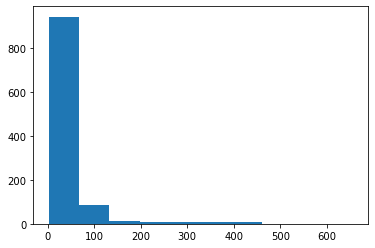

In [17]:
nonZeroCellLines = np.sum(cell_features.values != 0, axis=1)
print(nonZeroCellLines)
plt.hist(nonZeroCellLines)

In [18]:
cell_features.iloc[nonZeroCellLines.argmax(), :].value_counts()

1           655
0           346
TP53_mut      1
Name: 288, dtype: int64

### Drug Features

In [19]:
drug_features = pd.read_csv(_FOLDER+'Drug_Features.csv')
drug_features.shape

(265, 5)

In [20]:
drug_features.head()

,Drug ID,Drug Name,Synonyms,Target,Target Pathway
0,1,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling
1,3,Rapamycin,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",MTORC1,PI3K/MTOR signaling
2,5,Sunitinib,"Sutent, Sunitinib Malate, SU-11248","PDGFR, KIT, VEGFR, FLT3, RET, CSF1R",RTK signaling
3,6,PHA-665752,"PHA665752, PHA 665752",MET,RTK signaling
4,9,MG-132,"LLL cpd, MG 132, MG132","Proteasome, CAPN1",Protein stability and degradation


### Drug Response Data

In [21]:
drug_curves = pd.read_csv(_FOLDER+"normalised_dose_response_data.csv")
drug_curves.shape

(225384, 44)

In [22]:
drug_curves.head()

,Unnamed: 0,CELL_LINE_NAME,COSMIC_ID,DRUG_ID,DRUGID_COSMICID,FOLD_DILUTION,MAX_CONC,fd_num_0,fd_num_1,fd_num_2,...,per_slope_change_7,slope_0,slope_1,slope_2,slope_3,slope_4,slope_5,slope_6,slope_7,slope_8
0,0,HDQ-P1,1290922,332,332_1290922,2,10.240,0,0.111111,0.222222,...,-2.14694,0.354085,-0.371905,0.069255,0.450075,-0.049503,-0.131784,0.246947,-1.239447,1.421566
1,1,HDQ-P1,1290922,257,257_1290922,2,10.240,0,0.111111,0.222222,...,-30.3283,-0.275239,0.163481,0.586129,0.180903,-0.221430,-0.349017,0.157822,0.087103,-2.554585
2,2,HDQ-P1,1290922,245,245_1290922,2,40.000,0,0.111111,0.222222,...,-0.618543,-0.394857,-0.615137,0.485215,-0.923687,0.466260,2.837371,-5.409070,-3.468825,-1.323207
3,3,HDQ-P1,1290922,155,155_1290922,2,0.512,0,0.111111,0.222222,...,1.14591,0.791510,-0.964611,1.238764,1.046952,-0.652559,-1.921061,-0.541266,-0.480877,-1.031916
4,4,HDQ-P1,1290922,192,192_1290922,2,16.000,0,0.111111,0.222222,...,1.53355,0.317413,0.044115,-0.604783,0.510820,-0.431190,0.575779,2.380415,-0.793585,-2.010587


In [23]:
print("No unique drugs:", drug_curves["DRUG_ID"].nunique())
print("No unique cancer cell lines:", drug_curves["COSMIC_ID"].nunique())

No unique drugs: 265
No unique cancer cell lines: 1074


In [24]:
drug_curves.groupby("CELL_LINE_NAME")[["COSMIC_ID"]].size()

CELL_LINE_NAME
201T        185
22RV1       223
23132-87    216
42-MG-BA    217
451Lu       221
           ... 
YT          258
ZR-75-30     91
huH-1       224
no-10       241
no-11       265
Length: 1074, dtype: int64

In [25]:
conc_labels= ["fd_num_"+str(i) for i in range(10)]
resp_labels = ['norm_cells_'+str(i) for i in range(10)]

In [26]:
def createResponseCurve(response, x_labels, y_labels):
#     fig = plt.figure(figsize=(5, 5))
    plt.scatter(response[x_labels], response[y_labels])
    plt.title(str(response["DRUG_ID"]) + "_" + str(response["CELL_LINE_NAME"]))
    plt.xlabel("Scaled dosage")
    plt.ylabel("Normalised response")
    plt.show()

In [27]:
max_int = len(drug_curves.index)
rand_int = np.random.randint(0, max_int, 9)

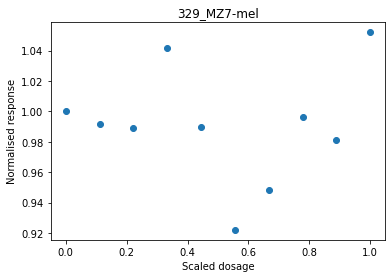

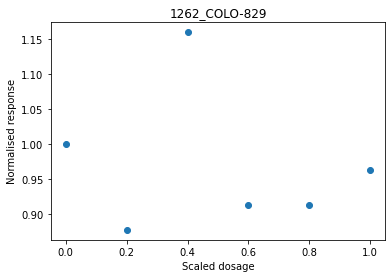

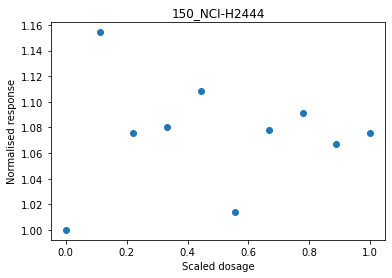

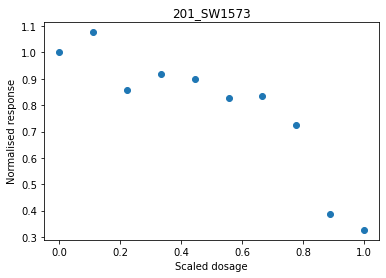

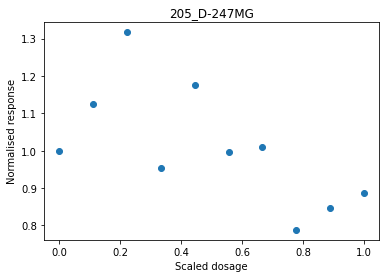

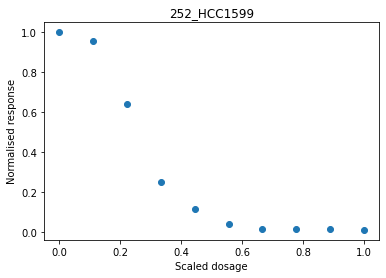

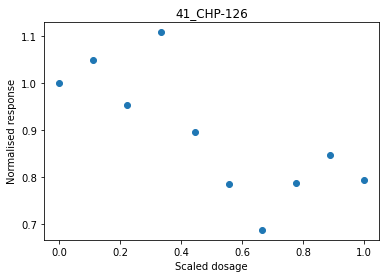

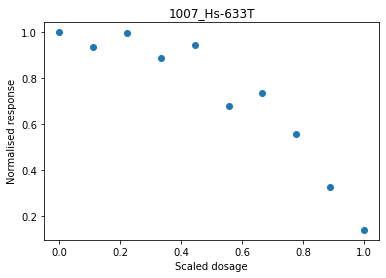

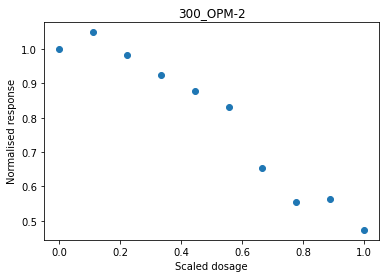

In [28]:
for index in rand_int:
    createResponseCurve(drug_curves.loc[index], conc_labels, resp_labels)